# Part 1 ‐ Exploratory data analysis

**Prompt**

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location.

* Aggregate these login counts based on 15 minute time intervals
* visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.
* report/illustrate important features of the demand, such as daily cycles.
* If there are data quality issues, please report them.

First, I'm importing packages, the dataset, checking the range of dates, and then plotting the entire timeseries. 

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [67]:
logins = pd.read_json('/Users/allankapoor/Documents/Springboard/ultimate_challenge/logins.json')

In [68]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [46]:
logins.sort_values('login_time',inplace=True)
logins.reset_index(inplace=True)
logins.drop(columns='index', inplace=True)

As requested in the prompt, I am resampling the dataset to counts each 15-minute increment.

In [54]:
logins_interval = logins.resample("15T", on='login_time').count()

In [56]:
logins.login_time.min()

Timestamp('1970-01-01 20:12:16')

In [57]:
logins.login_time.max()

Timestamp('1970-04-13 18:57:38')

In [156]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [58]:
logins_interval.rename(columns={'login_time':'count'}, inplace=True)

In [165]:
logins_freq = logins_interval.asfreq('15Min')

In [173]:
logins_freq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   count        9788 non-null   int64
 1   day_of_week  9788 non-null   int64
dtypes: int64(2)
memory usage: 487.4 KB


Here I'm checking if there are any noticeable periods where no logins occured for several 15-minute period back-to-back. This would suggest a data quality issue / gap in the dataset. However, we see that the longest stretch with no logins is only 5 (an hour and 15 minutes) and stretches of 5, 4, and 3 happen very infrequently. Based on this, we can be confident that there are no gaps in the dataset.

In [223]:
#boolean mask of periods with 0 logins
is_zero = pd.Series(logins_interval['count'] == 0).reset_index()
series = is_zero['count']
#using cumsum to count length of no login stretches
is_zero_cumsum = (~series).cumsum()[series].value_counts()
is_zero_cumsum.sort_values(ascending=False).head()

630     5
4422    4
4148    3
5064    3
3557    3
Name: count, dtype: int64

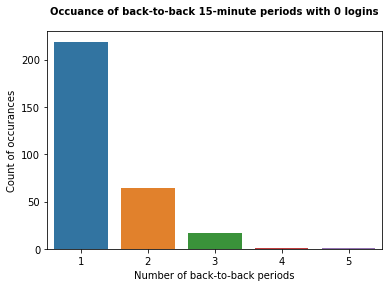

In [222]:
# count plot of occurance
ax = sns.countplot(x=is_zero_cumsum)
ax.set_title('Occuance of back-to-back 15-minute periods with 0 logins', weight='bold', fontsize=10, y=1.05)
ax.set_xlabel('Number of back-to-back periods')
ax.set_ylabel('Count of occurances')
plt.show()

logins_interval['day_of_week'] = logins_interval.index.dayofweek

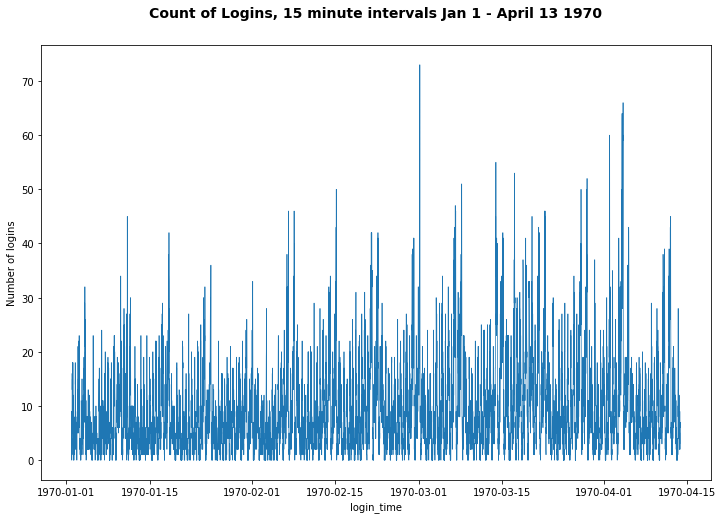

In [78]:
#plot timeseries
fig, ax = plt.subplots(ncols=1, figsize=(12, 8))
sns.lineplot(data=logins_interval, x='login_time', y='count', linewidth=0.7)

#labels
ax.set_title('Count of Logins, 15 minute intervals Jan 1 - April 13 1970', weight='bold', fontsize=14, y=1.05)
ax.set_ylabel('Number of logins')

plt.show()

The plot above is of the number of logins every 15 minutes for the entire 3.5 month time period. This is just quick plot to visualize the data - we can already see what looks like a weekly pattern. We can also see that the peak values each week seem to increase over the time period.

Zooming in on Monday and Tuesday of the first full week (below), we also see what might be a daily seasonality/oscillation.

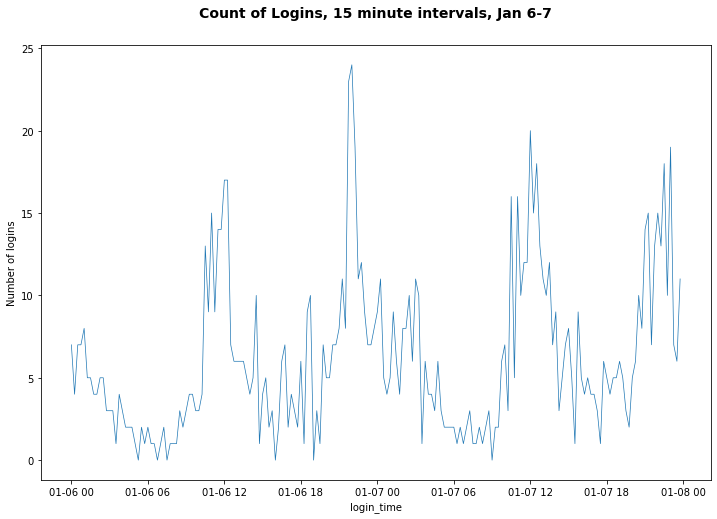

In [146]:
#plot timeseries
fig, ax = plt.subplots(ncols=1, figsize=(12, 8))
sns.lineplot(data=logins_interval.loc['1970-01-06' : '1970-01-07'], x='login_time', y='count', linewidth=0.7)

#labels
ax.set_title('Count of Logins, 15 minute intervals, Jan 6-7', weight='bold', fontsize=14, y=1.05)
ax.set_ylabel('Number of logins')

plt.show()

The plots above hint at seasonality but we need better tools. Below I'm defining a function to help visually inspect for seasonal patterns at different time frequencies.

In [103]:
import statsmodels.api as sm

def plot_seasonality(decompfreq, start_date, end_date):
    
    #decompose seasonality based on input frequency and start/end dates
    decomposition = sm.tsa.seasonal_decompose(x=logins_interval[start_date : end_date]['count'], model='additive', period=decompfreq)

    # Plot the original data, the trend, the seasonality, and the residuals
    fig, axes = plt.subplots(3, 1, figsize=(8,8,), sharex=True)
    decomposition.observed.plot(ax=axes[0], legend=False, color='r')
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1], legend=False, color='g')
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    #decomposition.resid.plot(ax=axes[3], legend=False, color='k')
    #axes[3].set_ylabel('Residual')

    plt.show()

First let's see if there is daily seasonality:

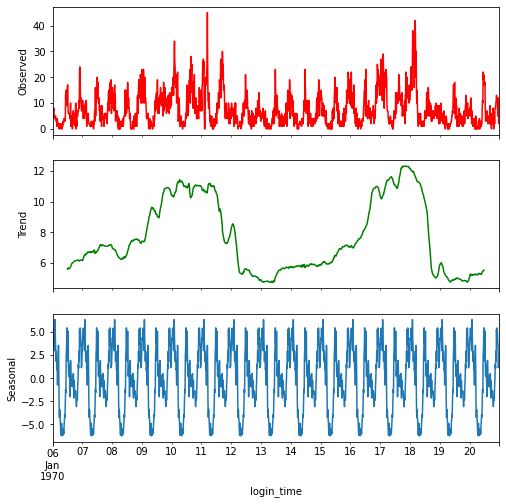

In [104]:
#looking at daily oscillations
decompfreq = ((24*60)//15)
plot_seasonality(decompfreq, '1970-01-06', '1970-01-20')

Above I deconstructed seasonality for daily oscillations across 3 weeks. The seasonal chart confirms that there is a  **daily seasonality**. The trend chart hints that once the daily oscillations are factored out, there is also a weekly oscillation. I look into that below.

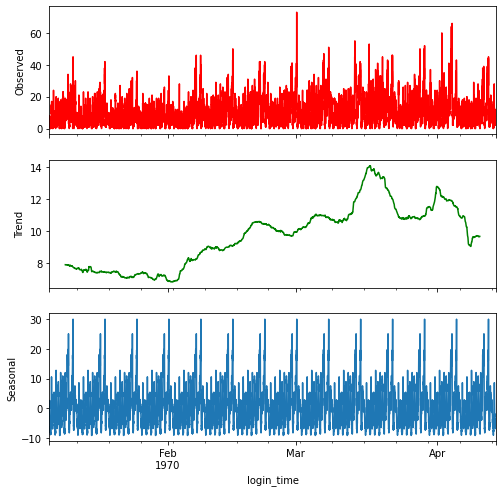

In [106]:
#looking at weekly oscillations
decompfreq = ((7*24*60)//15)
plot_seasonality(decompfreq, '1970-01-06', '1970-04-13')

Above I deconstructed seasonality for weekly oscillations over the entire timeperiod (just under 3.5 months). The seasonal chart does confirm that there is **weekly seasonality**, but we can still see the daily oscillations as well. With the weekly (and daily) oscillations factored out (Trend chart) we can see that there is a longer term trend as well.

Next, I calculate the average daily login login rate by day of the week across the entire timeseries. Below we can see the weekly pattern as well. Starting with Monday, logins increase to a max on Saturday, followed by a slight downturn on Sunday, and then a drop back to Monday levels.

In [122]:
logins_interval_week = pd.DataFrame(logins_interval['count'].resample("1D").sum())
logins_interval_week['day_of_week'] = logins_interval_week.index.dayofweek
logins_week_av = logins_interval_week.groupby('day_of_week').mean()

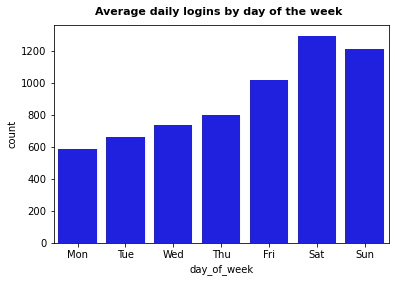

In [154]:
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ax = sns.barplot(data=logins_week_av, x=logins_week_av.index, y='count', color='b')
ax.set_title('Average daily logins by day of the week ', weight='bold', fontsize=11, y=1.02)
ax.set_xticklabels(days);

Below, I carry out a similar process but for hours of the day. The chart depicts average hourly logins by hour of the day across the entire timeseries. We can clearly see the daily oscillation that was identified using the daily seasonality deconstruction above.

The chart below we can see more specifics about this daily oscillation. Logins are lowest between 6-8 AM, rise until just before noon, go back down until around 5 pm when they start to rise again, peaking at about 10 pm. This is all expected and seems to follow the pattern of a workday. However, it is not clear why logins drop off slowly over night all the way to early morning.

It is important to note that we don't know if all these logins are in the same time zone.

In [144]:
logins_interval_day = pd.DataFrame(logins_interval['count'].resample("1H").sum())
logins_interval_day['hour_of_day'] = logins_interval_day.index.hour
logins_day_av = logins_interval_day.groupby('hour_of_day').mean()

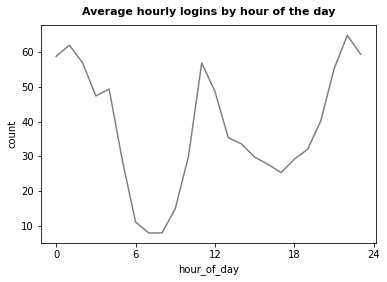

In [158]:
ax = sns.lineplot(data=logins_day_av, x=logins_day_av.index, y='count', color='gray')
ax.set_title('Average hourly logins by hour of the day', weight='bold', fontsize=11, y=1.02)
ax.set_xticks((0,6,12,18,24));

### Part 1 Key Takeaways

Here I summarize key takeaways from the EDA above.

**Observations**
 * Logins exhibit a daily cycle with two peaks and two troughs each day
 * Logins exhibit a weekly cycle with logins lowest on Monday, rising at at increasing rate until a peak on Saturday, followed by a dip on Sunday and then a major drop back to Monday.
 * Once these daily and weekly cycles are factored out, a longer term trend across the entire 3.5 month time period is visible. Average logins slowly decreased throughout January then increased until a peak in mid-March. Note that thsi is a background trend - the daily and weekly oscillations are much larger.

**Data quality issues**
 * The data obviously can't really be from 1970. It's unlear if this is an error or because it is fictional/dummy data. If it is an error, it is important to know the correct year because this might change the day of the week for each observation.
 * There appear to be no gaps in the dataset due to missing data or omissions

# Part 2 - Experiment and metrics design

**Prompt**

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

**Answer:** I would use *average profit margin per driver* as the key metric for the following reasons:
* Increasing the profit margin of of the ridershare service is the ultimate goal of the proposed change.
* This is preferred over revenue, because toll reimsursements might cancel out gains from increased revenue.
* Average profit margin per driver is recommended over total profit margin to avoid incorrect assumptions that could be made from only looking at total profit margin. For example, even if the same number of drivers are offered toll reimbursements vs no toll resimbursements perhaps more drivers in the reimsursement group would choose to drive each day.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

**Answer:** 

I would structure the experiment as an A/B test between two groups: reimbursement and no reimbursement. The key is to ensure that 
 * On day 1, for drivers starting in each city: provide 50% of drivers with the reimbursement, 50% of drivers without the reimsursement.
 * On day 2 (and each day following) recallibrate the split so that 50% of drivers starting in each city have the reibursement. Recallibration should be done with the least movement between groups as possible (since habitat formation may influence results for each driver).
 * After a period of 2 weeks (need at least 2 cycles) compare avergage profit margin per driver generated from both groups. Perform statitsical tests and inetrpret results (see below)

b) what statistical test(s) you will conduct to verify the significance of the observation

**Answer:** 

At 2 weeks, and then again at a month (4 weeks) I would compare the average profit margin per driver for each group (with reimbursement, without reimbursement). To verify that the results are signifant I would use a one-sided T-test for statistical significance at the 95% confidence interval (one-sided p-value of 0.05). I recommend a one-sided test because we want to verify that the higher average is trully higher (vs just testing if the averages are different). 

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**Answer:** 

If the p-value is less than 0.05 we can say that the difference is statistically significant at the 95% confidence interval, meaning that there is only a 1 in 20 chance that 

If there is a statistically signifint difference in the average profit per driver between the two groups, we can recommend that the policy either be fully implemented for all drivers going forward, or the policy should be rescinded. 

It's worth noting that Ultimate managers may not be proposing the optimal change. We want the drivers to use the reibursement to cross the bridge to the city with higher activity, not overuse the reimbursement or use it on days when there is no difference in activity between the cities. Therefore, I would recommend that the policy should be more nuanced:
 * Only reimburse drivers for crossing the bridge once each way per day
 * Only provide reimbursement on the weekdays (when there are differences in activity between the cities)

# Part 3 ‐ Predictive modeling

**Prompt**

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

## Q1
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Summary of the steps below (with key takeaways):
 * Load and inspect dataframe of users
 * Create target variable (user is active if last_trip_date is 30 days or less before last date in the dataset)
 * Look at class balance between target variable classes (there is some class imbalance but it is not severe)
 * Plot correlation matrix for continuous variables. Looks like there is not much multicolinearity except for between surge_pcnt and av_surge, which makes sense.
 * Loop through continuous features to explore relationship between a given feature and the target variable: create box plot, bar comparing means, histogram, and T-test of means. Some observations:
     * All distributions are very skewed
     * Several features have statistically significant (p<0.05) differences between mean of active/no active users
     * Others including avg_rating_of_driver, avg_surge, avg_rating_by_driver are not statistically significant 
 * Plots comparing target feature to categorical features: For each categorical variable I calculate and plot the percent of users that are active by each category. We can see that there are large differences in the percent of users that are active between users in different cities, between users with iPhopnes vs Android, and between users who use Ultimate Blak or not.
 

**37.61% of the observed users were retained** (i.e. took a trip within 30 days or less from the last recorded date in the dataset - 2014-06-01)

### Load and inspect dataframe

In [225]:
users = pd.read_json('/Users/allankapoor/Documents/Springboard/ultimate_challenge/ultimate_data_challenge.json')

In [226]:
users.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [227]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [228]:
users.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [230]:
# date columns to datetime format
users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)

In [231]:
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### Create Target Variable

In [244]:
#earliest date to still be considered active 
cuttoff_date = users.last_trip_date.max() - pd.Timedelta(days=30)
cuttoff_date

Timestamp('2014-06-01 00:00:00')

In [302]:
#creating target variable based on cuttoff date
mask = users.last_trip_date >= cuttoff_date
users.loc[mask,'active'] = 'Active'
users.loc[~mask, 'active'] = 'Non Active'

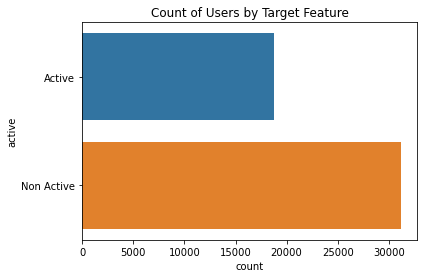

In [303]:
ax = sns.countplot(data=users, y='active')
ax.set_title('Count of Users by Target Feature')
plt.show()

Some class imbalance but not too bad.

In [319]:
#calculating proportion of active users
total_users = users.shape[0]
active_users = (users.active=='Active').sum()
pcnt_active = round(100*active_users/total_users, 2)

print(f'Proportion of users that are active/retained: {pcnt_active}%')

Proportion of users that are active/retained: 37.61%


### Correlations

Plot correlation matrix to see relationships between features. Target feature is not continuous so we can't include that.

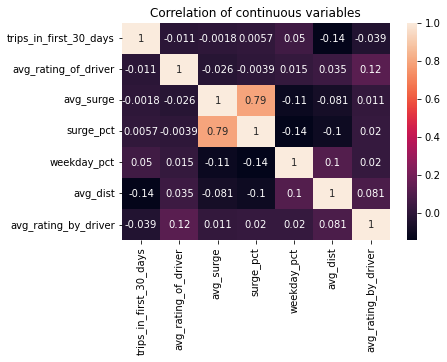

In [304]:
# Make a heatmap of the data
cont = ['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

users_cont = users[cont]

#plt.subplots(figsize=(12,10))
sns.heatmap(users_cont.corr(), annot=True)
plt.title('Correlation of continuous variables');

### Distributions, Statististical Significance

Here I loop through all continuous features to explore relationship between a given feature and the target variable:
 * Create box plot
 * Bar plot comparing means
 * Histogram
 * T-Test of the means

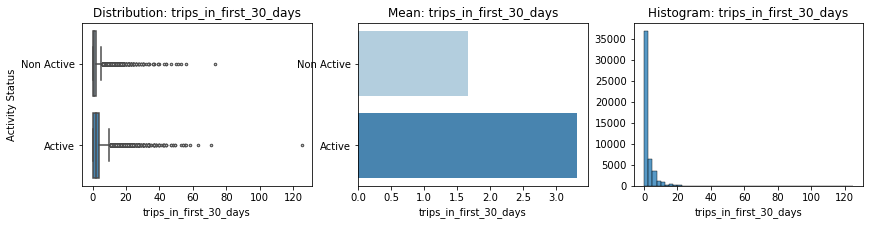

Two-tailed T test
t: 41.8782
p: 0.0


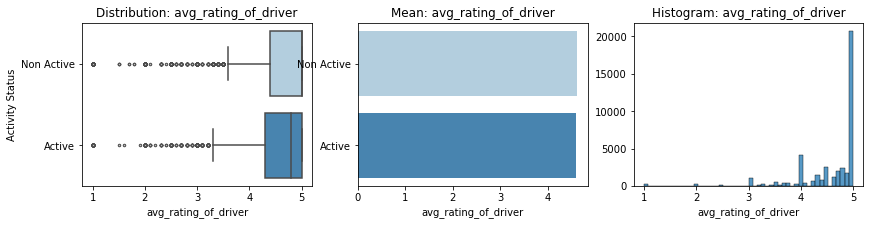

Two-tailed T test
t: nan
p: nan


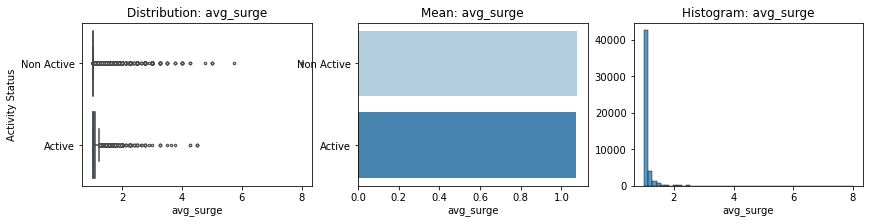

Two-tailed T test
t: -0.8247
p: 0.4095


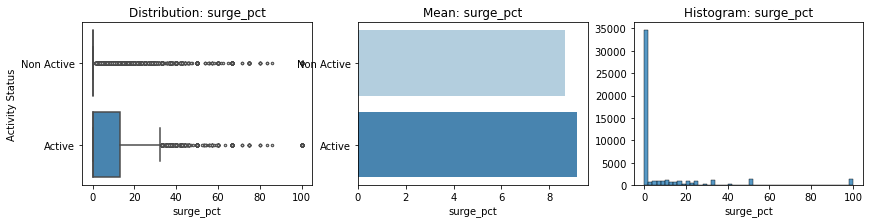

Two-tailed T test
t: 2.8695
p: 0.0041


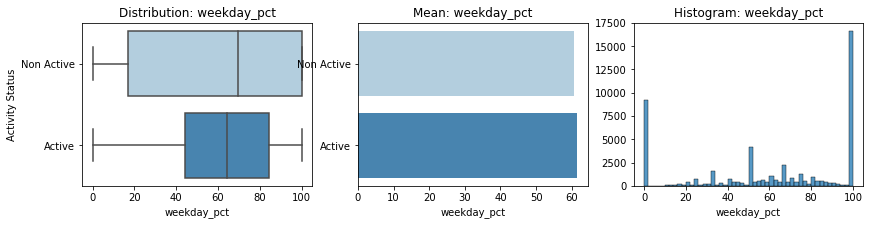

Two-tailed T test
t: 2.3455
p: 0.019


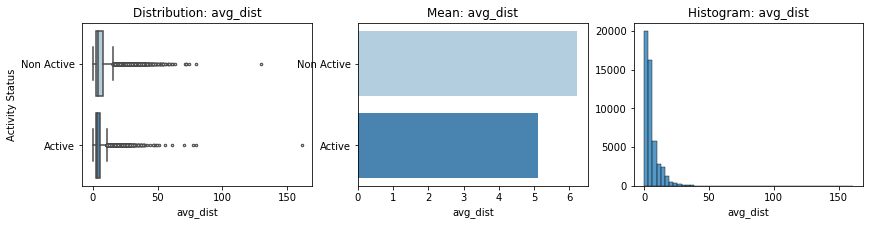

Two-tailed T test
t: -22.4057
p: 0.0


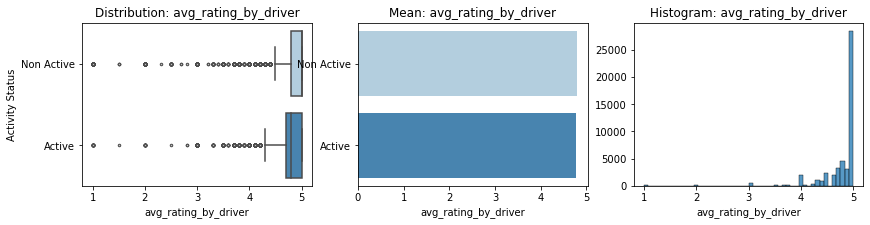

Two-tailed T test
t: nan
p: nan


In [305]:
# list of continuous features + target variable
cols= ['active','trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

# create dataframe for holding statistical test results
ttest_df = pd.DataFrame(data=cols[1:],columns=['Feature'])
ttest_df.set_index('Feature', inplace=True)
ttest_df['T-Score']=np.nan
ttest_df['P Value']=np.nan

# df with continous vars only
df = users[cols]

# style for boxplot outlier marks  
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none', marker='.')

# for each continuous feature: plot boxplot (by size), bar plot of means (by size), and histogram
# two-tailed t test, print t and p
for i, col in enumerate(df.columns[1:]):
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 3))
    
    # boxplot 
    sns.boxplot(x=col, y='active', data=df, palette='Blues', flierprops=flierprops, ax=ax1, order=['Non Active','Active'])

    # bar plot of means
    mean_table = users.groupby('active')[col].mean()
    sns.barplot(y=mean_table.index, x=mean_table, palette='Blues', ax=ax2,  order=['Non Active','Active'])
    
    # histogram
    sns.histplot(x=col, data=df, ax=ax3, bins=50)
    
    # set titles, labels
    ax1.set_title('Distribution: '+col)
    ax1.set_ylabel('Activity Status')
    ax2.set_title('Mean: '+col)
    ax2.set_ylabel('')
    ax3.set_title('Histogram: '+col)
    ax3.set_ylabel('')
    
    plt.show()
    
    #statistical test
    active_users = users[users['active']=='Active']
    nonactive_users = users[users['active']=='Non Active']
    t, p = stats.ttest_ind(active_users[col], nonactive_users[col], equal_var=False)
    t = round(t,4)
    p = round(p,4)
    ttest_df.loc[col,'T-Score'] = t
    ttest_df.loc[col,'P Value'] = p
    
    print('Two-tailed T test')
    print(f't: {t}')
    print(f'p: {p}')

### Fill NAs (Continuous)

There are missing values for both `avg_rating_by_driver` and `avg_rating_of_driver`. First I look at the mean, median, and standard devation for these variables. The mean and medians are quite close and standard deviations are relatively low.

Based on this information, and the fact that from the charts/p tests above it doesn't seem like either of these variables are strong predictors, I'm going to fill NAs with the mean and not worry too much about them.

If either feature appeared to be highly important, I would likely:
* Drop records with nulls for `avg_rating_by_driver` since there are only 200 out of 5000 records
* Explore model-based imputation for `avg_rating_of_driver` since there are more than 600 out of 5000 records

In [378]:
print(users.avg_rating_by_driver.mean())
print(users.avg_rating_by_driver.median())
print(users.avg_rating_by_driver.std())

4.77815819594771
5.0
0.44665179346562006


In [377]:
print(users.avg_rating_of_driver.mean())
print(users.avg_rating_of_driver.median())
print(users.avg_rating_of_driver.std())

4.601559291274655
4.9
0.6173384560411342


In [379]:
users = users.fillna({'avg_rating_by_driver':users.avg_rating_by_driver.mean(),
                     'avg_rating_of_driver':users.avg_rating_of_driver.mean()})

In [380]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active                  50000 non-null  object

### Compare Categorical Variables to Target Feature

For each categorical variable I calculate and plot the percent of users that are active by each category. We can see that there are large differences in the percent of users that are active between users in different cities, between users with iPhopnes vs Android, and between users who use Ultimate Blak or not.

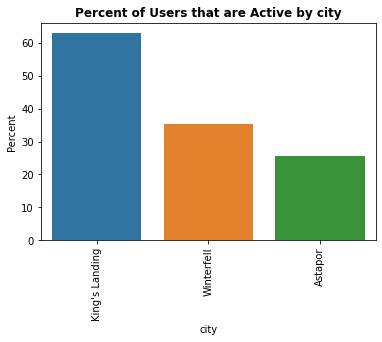

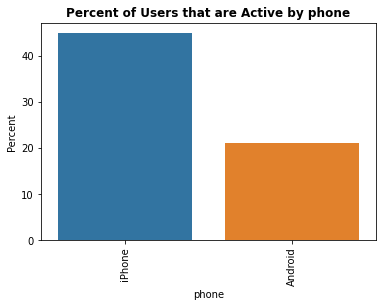

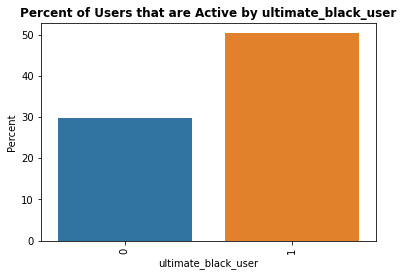

In [312]:
cat_feats = ['active','city','phone','ultimate_black_user']

users_cat = users.loc[:,cat_feats]
ult_blk_mask = users_cat.ultimate_black_user==True
users_cat.loc[ult_blk_mask, 'ultimate_black_user'] = 1
users_cat.loc[~ult_blk_mask, 'ultimate_black_user'] = 0

for feat in cat_feats[1:]:
    
    crosstab = pd.crosstab(users_cat['active'], users_cat[feat]).T
    crosstab['Pcnt_Active'] = round(crosstab['Active']/(crosstab['Active']+crosstab['Non Active'])*100,2)
    crosstab.sort_values('Pcnt_Active', ascending=False, inplace=True)
    sns.barplot(data=crosstab, x=crosstab.index, y='Pcnt_Active')
    locs, labels = plt.xticks()
    plt.ylabel('Percent')
    plt.xlabel(feat)
    plt.title(f'Percent of Users that are Active by {feat}', weight='bold')
    plt.setp(labels, rotation=90)
    plt.show()

### Handle NAs (Categorical)

There are missing values for the `phone` column. Based on the charts above it appears that there is a a substantial difference in activitiy status between users with Android vs. iPhone. I don't want to loose this predictive capability - so I am choosing to drop records with missing values for this column entirely.

In [399]:
users = users.dropna(subset=['phone'])

## Q2.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [400]:
#imports
from sklearn.model_selection import train_test_split

### Transforming Continuous Variables

In [401]:
# get summary statistics + skew/kurtosis for each continuous feature
exp_cont = ['trips_in_first_30_days', 'avg_rating_of_driver','avg_surge',
            'surge_pct', 'weekday_pct', 'avg_dist','avg_rating_by_driver']

users_describe = users[exp_cont].describe().T
users_describe['skew'] = users[users_describe.index].skew()
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
users_describe['skew_class'] = pd.cut(abs(users_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
users_describe['kurtosis'] = users[users_describe.index].kurtosis()

In [402]:
# shifting values so there are no negative/0 values
# by adding absolute value of min val to columns with mins <=0
# this is to allow variables to be log transformed
users_no_zeros = users.loc[:,exp_cont]
for col in users_no_zeros.columns:
    if users_no_zeros[col].min() <= 0:
        users_no_zeros.loc[:,col] = users_no_zeros[col] + abs(users_no_zeros[col].min()) + 0.0001

In [403]:
# get summary statistics + skew/kurtosis for each continuous feature (now that feature vales are shifted)
users_noZ_describe = users_no_zeros.describe().T
users_noZ_describe['skew'] = users[users_noZ_describe.index].skew()

# assign "skew classes" based on general rule of thumb for interpreting skew values
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
users_noZ_describe['skew_class'] = pd.cut(abs(users_noZ_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
users_noZ_describe['kurtosis'] = users[users_noZ_describe.index].kurtosis()
users_noZ_describe

,count,mean,std,min,25%,50%,75%,max,skew,skew_class,kurtosis
trips_in_first_30_days,49604.0,2.277356,3.793300,0.0001,0.0001,1.0001,3.0001,125.0001,5.180064,High,56.878885
avg_rating_of_driver,49604.0,4.601482,0.565227,1.0000,4.5000,4.7000,5.0000,5.0000,-2.651528,High,10.281684
avg_surge,49604.0,1.074991,0.222666,1.0000,1.0000,1.0000,1.0500,8.0000,6.814926,High,77.204384
surge_pct,49604.0,8.875414,19.989018,0.0001,0.0001,0.0001,8.7001,100.0001,3.138105,High,10.390131
weekday_pct,49604.0,60.883932,37.086239,0.0001,33.3001,66.7001,100.0001,100.0001,-0.476086,Low,-1.156019
avg_dist,49604.0,5.785518,5.669709,0.0001,2.4201,3.8801,6.9301,160.9601,3.312237,High,25.466388
avg_rating_by_driver,49604.0,4.777862,0.446220,1.0000,4.7000,5.0000,5.0000,5.0000,-4.135126,High,24.299509


In [404]:
def test_transformations(df, col):
        '''
        For col in df, tests several transformations and returns the best transformation and the resulting skew
        '''
    
        #get skew of different transformations
        orig = df[col].skew()
        logn = np.log(df[col]).skew()
        log10 = np.log10(df[col]).skew()
        sqrt = np.sqrt(df[col]).skew()
        cbrt = np.cbrt(df[col]).skew()
        #recip = (1 / df[col]).skew()
        sq = (df[col]**2).skew()
        cb = (df[col]**3).skew()
        
        transformation_list = ['none','logn','log10','sqrt','cbrt','sq','cb'] # 'recip'
        skew_list = [abs(x) for x in [orig, logn, log10, sqrt, cbrt, sq, cb]] # recip
        
        #find min skew
        min_skew = min(skew_list)
        min_index = skew_list.index(min_skew)
        best_transformation = transformation_list[min_index]
        
        print(f'best transformation: {best_transformation}')
        
        print(f'orig skew: {round(orig,3)}')
        print(f'logn skew: {round(logn,3)}')
        print(f'log10 skew: {round(log10,3)}')
        print(f'sqrt skew: {round(sqrt,3)}')
        print(f'cbrt skew: {round(cbrt,3)}')
        #print(f'recip skew: {round(recip,3)}')
        print(f'sq skew: {round(sq,3)}')
        print(f'cb skew: {round(cb,3)}')
        
        return best_transformation, min_skew

In [405]:
#test transformation for each explanatory feature and record
for col in users_no_zeros.columns:
    print(f'------- {col} -------')
    
    best, skew = test_transformations(users_no_zeros, col)
    
    users_noZ_describe.loc[col,'best_trans'] = best
    users_noZ_describe.loc[col,'abs_trans_skew'] = skew

------- trips_in_first_30_days -------
best transformation: cbrt
orig skew: 5.18
logn skew: -0.756
log10 skew: -0.756
sqrt skew: 1.07
cbrt skew: 0.13
sq skew: 51.992
cb skew: 161.481
------- avg_rating_of_driver -------
best transformation: cb
orig skew: -2.652
logn skew: -4.953
log10 skew: -4.953
sqrt skew: -3.552
cbrt skew: -3.956
sq skew: -1.708
cb skew: -1.246
------- avg_surge -------
best transformation: log10
orig skew: 6.815
logn skew: 4.082
log10 skew: 4.082
sqrt skew: 5.084
cbrt skew: 4.695
sq skew: 17.92
cb skew: 63.688
------- surge_pct -------
best transformation: log10
orig skew: 3.138
logn skew: 0.837
log10 skew: 0.837
sqrt skew: 1.656
cbrt skew: 1.231
sq skew: 4.854
cb skew: 5.393
------- weekday_pct -------
best transformation: sq
orig skew: -0.476
logn skew: -1.607
log10 skew: -1.607
sqrt skew: -1.081
cbrt skew: -1.319
sq skew: 0.099
cb skew: 0.332
------- avg_dist -------
best transformation: cbrt
orig skew: 3.312
logn skew: -3.573
log10 skew: -3.573
sqrt skew: 1.326

In [406]:
# return a table summarizing the transformation tests. I compare the skew of the original data to the skew of
# the transformed data and see that I have been able to reduce skew for some features.

users_noZ_describe['trans_skew_class'] = pd.cut(users_noZ_describe['abs_trans_skew'], bins, labels=labels, ordered=False, include_lowest=True)

users_noZ_describe[['skew','skew_class','best_trans','abs_trans_skew','trans_skew_class']].sort_values('abs_trans_skew', ascending=False)

,skew,skew_class,best_trans,abs_trans_skew,trans_skew_class
avg_surge,6.814926,High,log10,4.081950,High
avg_rating_by_driver,-4.135126,High,cb,2.214442,High
avg_rating_of_driver,-2.651528,High,cb,1.246036,High
surge_pct,3.138105,High,log10,0.837323,Med
avg_dist,3.312237,High,cbrt,0.787418,Med
trips_in_first_30_days,5.180064,High,cbrt,0.130184,Low
weekday_pct,-0.476086,Low,sq,0.099077,Low


In [407]:
# now, I apply the best transformation identified for each continuous feature based on the above process
users_trans = users_no_zeros.copy()

for col in users_trans:
    
    #get best transformation
    trans = users_noZ_describe.loc[col,'best_trans']
    
    #apply best transformation
    if trans == 'none':
        users_trans[col] = users_trans[col]
    elif trans == 'logn':
        users_trans[col] = np.log(users_trans[col])
    elif trans == 'log10':
        users_trans[col] = np.log10(users_trans[col])
    elif trans == 'sqrt':
        users_trans[col] = np.sqrt(users_trans[col])
    elif trans == 'cbrt':
        users_trans[col] = np.cbrt(users_trans[col])
    elif trans == 'recip':
        users_trans[col] = 1/users_trans[col]
    elif trans == 'sq':
        users_trans[col] = users_trans[col]**2
    elif trans == 'cb':
        users_trans[col] = users_trans[col]**3
    else:
        print(f'error at {col}')

### Other Preprocessing

In [408]:
#merge transformed continuous variables with categorical variables
users_preprocessed = pd.concat([users_trans, users[cat_feats]], axis=1)
users_preprocessed.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city,phone,ultimate_black_user
0,1.587414,103.823,0.041393,1.187524,2134.44924,1.542503,125.000,Active,King's Landing,iPhone,True
1,0.046416,125.000,0.000000,-4.000000,2500.01000,2.021444,125.000,Non Active,Astapor,Android,False
2,1.442266,79.507,0.000000,-4.000000,10000.02000,0.916605,125.000,Non Active,Astapor,iPhone,False
3,2.080092,97.336,0.056905,1.301032,6400.01600,1.331405,117.649,Active,King's Landing,iPhone,True
4,2.410148,85.184,0.075547,1.071886,6789.77648,1.462804,117.649,Non Active,Winterfell,Android,False


In [409]:
# convert target feature to a binary numeric variable 
# making active 0 and non-active 1 so that non-active is the positive class
mask = users_preprocessed.active == 'Active'
users_preprocessed.loc[mask,'active'] = 0
users_preprocessed.loc[~mask, 'active'] = 1

In [410]:
# one hot encode categorical features
users_preprocessed = pd.get_dummies(users_preprocessed, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [411]:
users_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trips_in_first_30_days    49604 non-null  float64
 1   avg_rating_of_driver      49604 non-null  float64
 2   avg_surge                 49604 non-null  float64
 3   surge_pct                 49604 non-null  float64
 4   weekday_pct               49604 non-null  float64
 5   avg_dist                  49604 non-null  float64
 6   avg_rating_by_driver      49604 non-null  float64
 7   active                    49604 non-null  object 
 8   city_King's Landing       49604 non-null  uint8  
 9   city_Winterfell           49604 non-null  uint8  
 10  phone_iPhone              49604 non-null  uint8  
 11  ultimate_black_user_True  49604 non-null  uint8  
dtypes: float64(7), object(1), uint8(4)
memory usage: 3.6+ MB


In [440]:
# Create feature and target arrays
X = users_preprocessed.drop(columns=['active'])
y = users_preprocessed.active
y = y.to_numpy().astype('int')

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123, stratify=y)

# Split training into training_sub and validation
#X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=123, stratify=y_train)

### Modelling

In this section I build and test two models:
 * Logistic Regression
 * Random Forest
    
I evaluate performance of each model using 10-fold cross validation using F1 score as the evaulation metric. I chose the F1 score because in this context we care more about identifying the positive class (non-active users) and there is a class imbalance (positive class makes up 37.6% of the records).

In [471]:
#modeling imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler

In [469]:
def Pipeline_CV_GridSearch(i_model, param_grid, cv_type):
    
    '''Carry out a random search with 10-fold cross valididation on a given model given a hyperparameter grid'''

    # scale
    scale = MinMaxScaler()

    # instantiate model
    model = i_model

    # define pipeline
    steps = [('scale', scale), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # define cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

    # define search
    if cv_type=='grid':
        grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
    elif cv_type=='random':
        grid = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=cv, scoring='f1')
    else:
        pass
    
    # execute the grid search
    grid_result = grid.fit(X_train, y_train)

    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    return grid_result

### Logistic Regression

Below I tune a logistic regression model with various options for solver and C. 

The best performing combination achieves a mean CV F1 score of 0.76 - which is good but not great.

By extracting the coefficients from the best performing model we can get a sense for the relative importance of the explanatory features. All appear to have some predictive power so I will not drop any. These coefficients contain valuable insights - for example it looks like higher average surge is a very strong predictor of inactivity, meaning that surge pricing may be pushing users away from the platform.

In [446]:
lg = LogisticRegression(random_state=13, class_weight='balanced', max_iter=100)

lg_params = {'model__solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
            'model__C': [100, 10, 1.0, 0.1, 0.01]}

lg_result = Pipeline_CV_GridSearch(lg, lg_params, 'grid')

Best: 0.761369 using {'model__C': 100, 'model__solver': 'saga'}


In [468]:
coef = lg_result.best_estimator_[1].coef_
coefs_df = pd.DataFrame(coef, columns=X_train.columns).T.rename(columns={0:'coeff'})
coefs_df['abs_coeff'] = abs(coefs_df['coeff'])
coefs_df.sort_values('abs_coeff', ascending=False, inplace=True)
coefs_df

,coeff,abs_coeff
avg_surge,6.762828,6.762828
surge_pct,-2.075679,2.075679
city_King's Landing,-1.718403,1.718403
phone_iPhone,-1.051660,1.051660
ultimate_black_user_True,-0.879566,0.879566
avg_rating_by_driver,0.871198,0.871198
avg_dist,0.547703,0.547703
city_Winterfell,-0.544148,0.544148
trips_in_first_30_days,-0.357545,0.357545
weekday_pct,0.315136,0.315136


### Random Forest

Now I try a random forest classifier - this time using random search (100 permutations) instead of grid search because there are more paramaters/parameter values to try.

Random forest achieves a mean CV F1 score of 0.8205 which is much better than logistic regression.

In [472]:
rf = RandomForestClassifier()

rf_params = {'model__n_estimators': [50, 75, 100, 125, 150, 200],
             'model__max_depth' : list(range(2,15)),
             'model__criterion' :['gini', 'entropy'],
             'model__max_features': ['auto', 'sqrt', 'log2'],
             'model__class_weight': ['balanced', 'balanced_subsample']}

rf_result = Pipeline_CV_GridSearch(rf, rf_params, 'random')

Best: 0.820545 using {'model__n_estimators': 200, 'model__max_features': 'sqrt', 'model__max_depth': 14, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}


In [493]:
#invesigate CV results
cv_rf = pd.DataFrame(rf_result.cv_results_).sort_values('rank_test_score')[['mean_test_score', 'std_test_score', 'rank_test_score']].head(5)
cv_rf

,mean_test_score,std_test_score,rank_test_score
64,0.820545,0.004836,1
74,0.820524,0.005295,2
12,0.819907,0.004904,3
29,0.819776,0.005573,4
38,0.819685,0.003464,5


### Light GBM

Now I try a gradient boosting model. I picked LightGBM because of its combination of speed and high performance, but also because it is easy to see feature importances.

LightGBM achieves a mean CV F1 score of 0.8219 which just edges out Random Forest (although given.

In [485]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(is_unbalance=True, verbose=-1)

# parameter grid - these ranges were refined through a few iterations that are not shown here
lgbm_params = {'model__max_depth':range(3,12),
              'model__num_leaves': np.arange(20, 3000,20),
             'model__n_estimators': np.arange(50,1000,50),
             'model__learning_rate': np.arange(0.01,0.3,0.2),
             'model__lambda_l1':np.arange(1,100,10),
             'model__min_gain_to_split':np.arange(0,15),
             'model__bagging_fraction': np.arange(0.2,0.95, 0.1)}

In [486]:
lgbm_result = Pipeline_CV_GridSearch(lgbm, lgbm_params, 'random')

Best: 0.821929 using {'model__num_leaves': 380, 'model__n_estimators': 100, 'model__min_gain_to_split': 4, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__lambda_l1': 21, 'model__bagging_fraction': 0.8000000000000003}


In [489]:
pd.DataFrame(lgbm_result.cv_results_).sort_values('rank_test_score')[['mean_test_score', 'std_test_score', 'rank_test_score']].head(5)

,mean_test_score,std_test_score,rank_test_score
80,0.821929,0.004912,1
71,0.820967,0.005035,2
16,0.820464,0.005609,3
44,0.820345,0.004817,4
20,0.819258,0.006003,5


In [487]:
lgbm_result.best_estimator_

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 LGBMClassifier(bagging_fraction=0.8000000000000003,
                                is_unbalance=True, lambda_l1=21,
                                learning_rate=0.01, max_depth=8,
                                min_gain_to_split=4, num_leaves=380,
                                verbose=-1))])

In [496]:
#create sorted dataframe of feature importance
from lightgbm import plot_importance
best_model = lgbm_result.best_estimator_.fit(X_train, y_train)
feat_importance = best_model.named_steps['model'].feature_importances_
col_names = X_train.columns
lgb_importances = pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

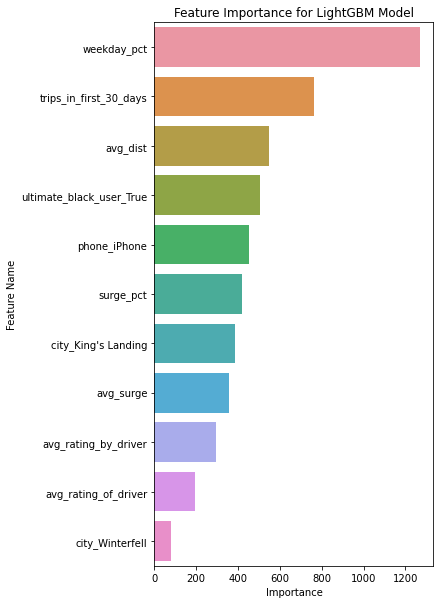

In [497]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

### Best Model - Validation on Test Set

LightGBM is performing best, so now I try it on the unseen test set. I calculated several additional evaluation metrics and plotted confusion matrices. *Note that in the matrices 0=active and 1=non-active.*

The model acheives an **F1 score of 0.8232** on the test data, which is slighty better than it acheived during cross validation.

Some observations based on these results:
 * The confusion matrices show that 30% of active users are being incorrectly predicted as non-active
 * If the goal is to predict churn and target users in danger of leaving the service in some way, resources could be wasted if our false positive rate is too high
 * Given more time, we might:
     * Optimize the prediction threshold away from 50% (i.e. be more certain that a user predited to churn will actually churn)
     * Try a different evaulation metric - Fbeta with beta=0.5 instead of F1 score would penalize false positives more.

In [498]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score

[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] lambda_l1 is set=21, reg_alpha=0.0 will be ignored. Current value: lambda_l1=21
----- EVAL METRICS -----
F1: 0.8232
Precision: 0.8191
Recall: 0.8272
ROCAUC: 0.7623


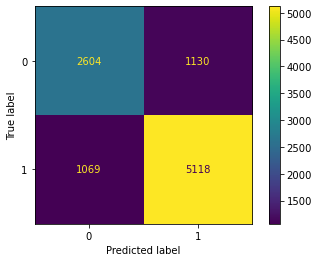

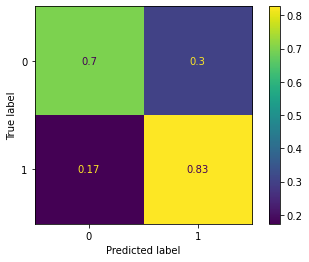

In [501]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# fit model to training data
model = lgbm_result.best_estimator_.fit(X_train, y_train)

# predict on validation set
y_pred = model.predict(X_test)

# calculate other evaluation metrics
precision = round(precision_score(y_test, y_pred),4)
recall = round(recall_score(y_test, y_pred),4)
f1 = round(f1_score(y_test, y_pred),4)
roc_auc = round(roc_auc_score(y_test, y_pred),4)

#plot confusion matrix (on validation data)
plot_confusion_matrix(model, X_test, y_test, labels=None, sample_weight=None, normalize=None);

#plot confusion matrix (on validation data)
plot_confusion_matrix(model, X_test, y_test, labels=None, sample_weight=None, normalize='true');

# print evaluation metrics
print('----- EVAL METRICS -----')
print(f'F1: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROCAUC: {roc_auc}')

### Potential Areas for Improvement

Given more time I would take additional actions:

**Data Wrangling/Preprocessing**
* **Refine transformation step:** In this notebook I applied a quick/automated approach to determining the best transformations for each column based on skew reduction. I did not do a thorough visual inspection of the results to make sure they are actually increasing the normality of the distributions. I also did not throughouly inspect outliers - removing or adjusting them may increase normality of distributions more naturally than the transformations.
* **Further Investigate Missing Values:** Given that the average driver rating and average rider rating did not seem to have a strong correlation with the target feature I imputed missing values for these columns based on the mean. However, I did not investigate further to see if the missing values were not at random. A missing driver rating could mean that the user was disengaged/disinterested with the service and could be a predictor itself. A missing rider rating could mean that the user had only taken a few rides.

**Modelling**
* **Optimize Hyperparameter Tuning:** For the sake of simplicity I used GridSearch/Randomsearch for tuning the hyperparameters of my models. I would likely achieve better results using a hyperparameter optimization framework - I have acheived good results using Optuna for other projects.
* **Consider other evaluation metrics:** As mentioned above the confusion matrices showed that high false positive rate which might lead to wasted resources if this mdodel is used to make business decisions. I would experiment with changing the evaluation metric to Fbeta with beta=0.5 (penalizes FPs more) or adjusting prediction threshold based on the ROC curve.

**Intrepreting Results**
* **Investigate LogReg Coefficients vs LightGBM Feature Importances**: The LogReg coefficients and the LightGBM feature importances appeared to emphasize different features as being most important for prediction. This is suspect and I would want to dig deeper to figure out why this is happening.
* **Leverage SHAP to Extract more Insights:** In a similar vein, I would leverage the SHAP (SHapley Additive exPlanations) package to further understand the output of the best performing model. This might lead to additional insights that could inform business decisions.

## Q3

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Ultimate might lverage insights gained from this process in two ways:

**Churn prediction:** The model predicts which users are likely to be inactive after 6 months. Once put in production, the model could be used to identify users at risk of churn, who could then be targetted with various offers or other strategies to increase their engagement/activity. Caution would have to be taken that whatever actions are taken for at-risk users do not remind or convince them to remove the platform from their phones.

**Insights into what causes inactivity:** While further refinement and analysis is likely necessary, the coefficients from the Logistic Regression model and the feature importances from the Light GBM suggest which . A subset of these Ultimate has direct control over - including 

For example, the coefficient with the highest value in the LogReg model is av_surge, which also has a substantial feature importance value. This suggests that high surge pricing pushes users away. While surge pricing may generate increased short term profits, Ultimate may want to consider adjusting surge pricing algorithms with the objective of maximizing revenue while maintaining retention.

Another example is user's city of residence. The EDA and both models suggests that users from King's Landing are most likely to remain active while users from Winterfell and AStapor are more likely to become inactive. While the reasons for this can not be ascertained from the model this suggests an area that should be investigated futher. Perhaps the cause is demographic or spatial factors outside of Ultimate's control, but perhaps Ultimate has not targeted advertizing in those cities enough.